In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

## Start a spark session and read data into dataframe

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

23/11/18 23:19:42 WARN Utils: Your hostname, Rish01-arch resolves to a loopback address: 127.0.1.1; using 192.168.0.110 instead (on interface wlan0)
23/11/18 23:19:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/18 23:19:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#------------------------------------------Features from the dataset-------------------------------------------#
# Age : Age of the patient
# Sex : Sex of the patient
# exang: exercise induced angina (1 = yes; 0 = no)
# ca: number of major vessels (0-3)
# cp : Chest Pain type chest pain type
#     Value 1: typical angina
#     Value 2: atypical angina
#     Value 3: non-anginal pain
#     Value 4: asymptomatic

# trtbps : resting blood pressure (in mm Hg)
# chol : cholestoral in mg/dl fetched via BMI sensor
# fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

# rest_ecg : resting electrocardiographic results
#     Value 0: normal
#     Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
#     Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

# thalach : maximum heart rate achieved
# target : 0= less chance of heart attack 1= more chance of heart attack


In [4]:
# Read the csv dataset
file_location = "./heart.csv"
df = spark.read.csv(file_location, header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trtbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalachh: integer (nullable = true)
 |-- exng: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slp: integer (nullable = true)
 |-- caa: integer (nullable = true)
 |-- thall: integer (nullable = true)
 |-- output: integer (nullable = true)



In [6]:
df.show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|     1|
| 57|  1|  0|   140| 192|  0|      1|     148|   0|    0.4|  1|  0|    1|     1|
| 56|  0|  1|   140| 294|  0|      0|     153|   0|    1.3|  1|  0|    2|     1|
| 44|  1|  1|   120| 263|  0|      1|     173|   0|    0.0|  2|  0|    3|     1|
| 52|  1|  2|   172| 199|  1|      1|     162|   0|    0.5|  2|  0|    3|     1|
| 57|  1|  2|   150| 168|  0

In [7]:
categorical_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]

## Exploratory data analysis

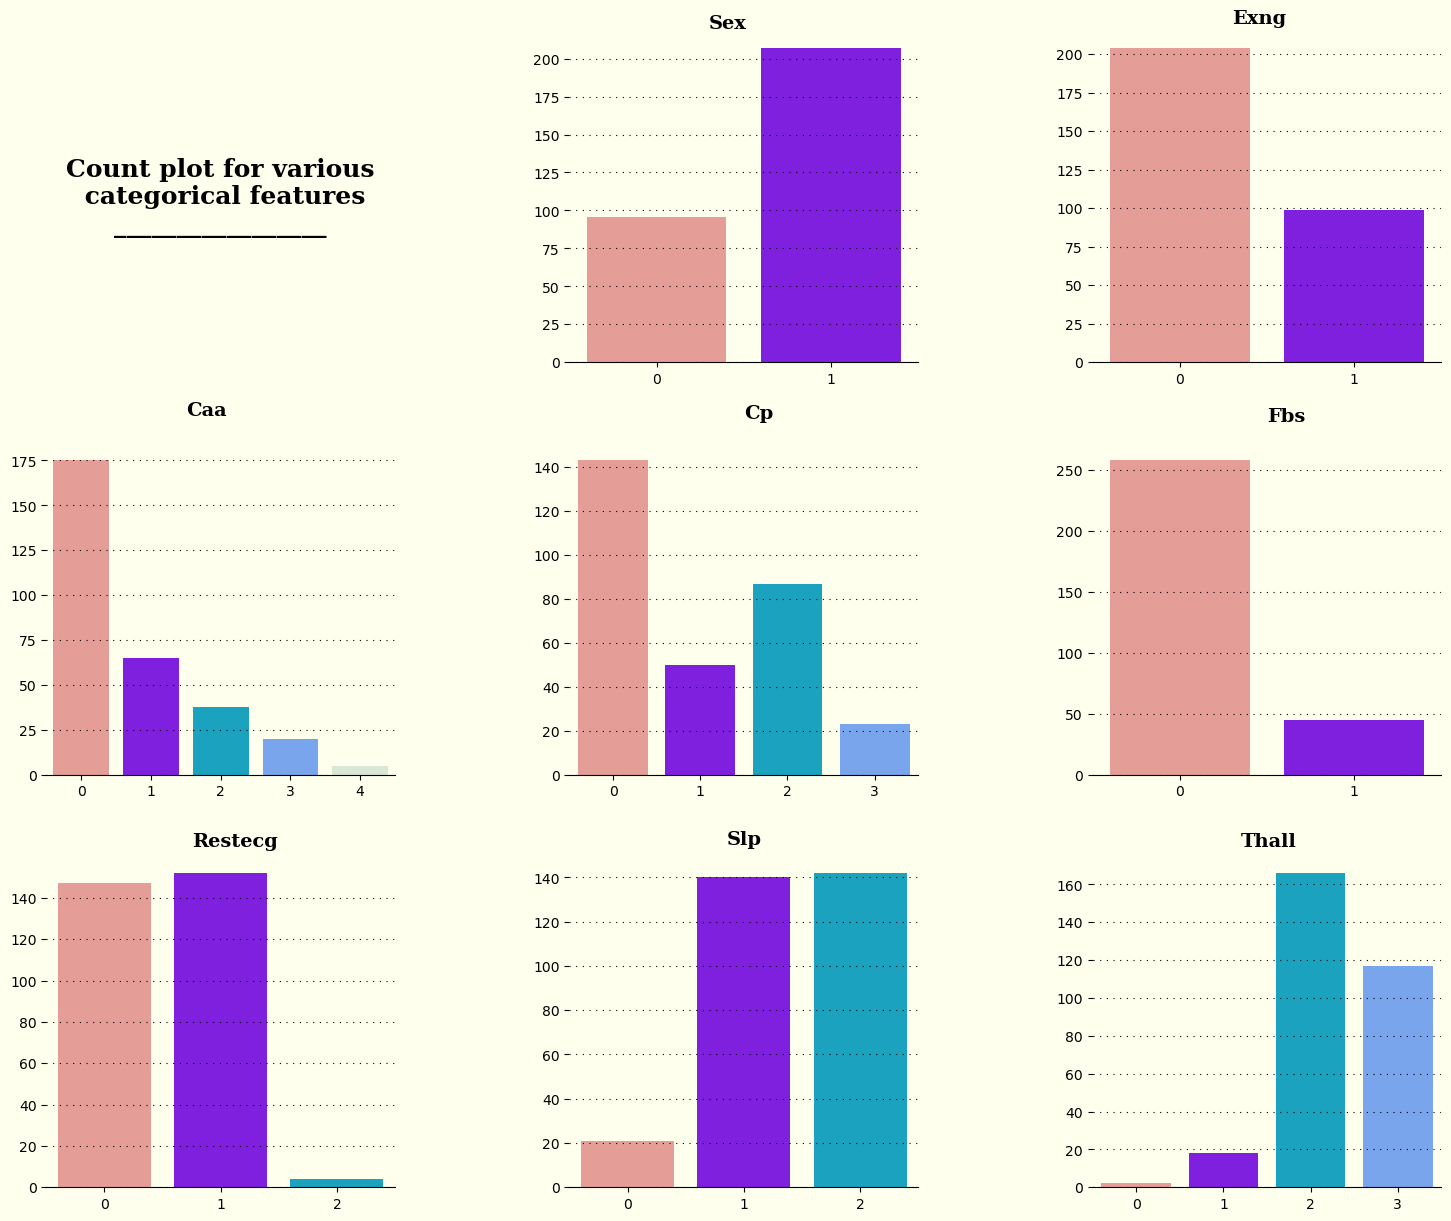

In [8]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = df.toPandas()

fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#FFFFEE"
color_palette = ["#f1948a","#8000ff","#00b4d9","#66a1ff","#d9ead3"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color) 
ax8.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=pandas_df,x='sex',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=pandas_df,x='exng',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=pandas_df,x='caa',palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=pandas_df,x='cp',palette=color_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=pandas_df,x='fbs',palette=color_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=pandas_df,x='restecg',palette=color_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=pandas_df,x='slp',palette=color_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=pandas_df,x='thall',palette=color_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

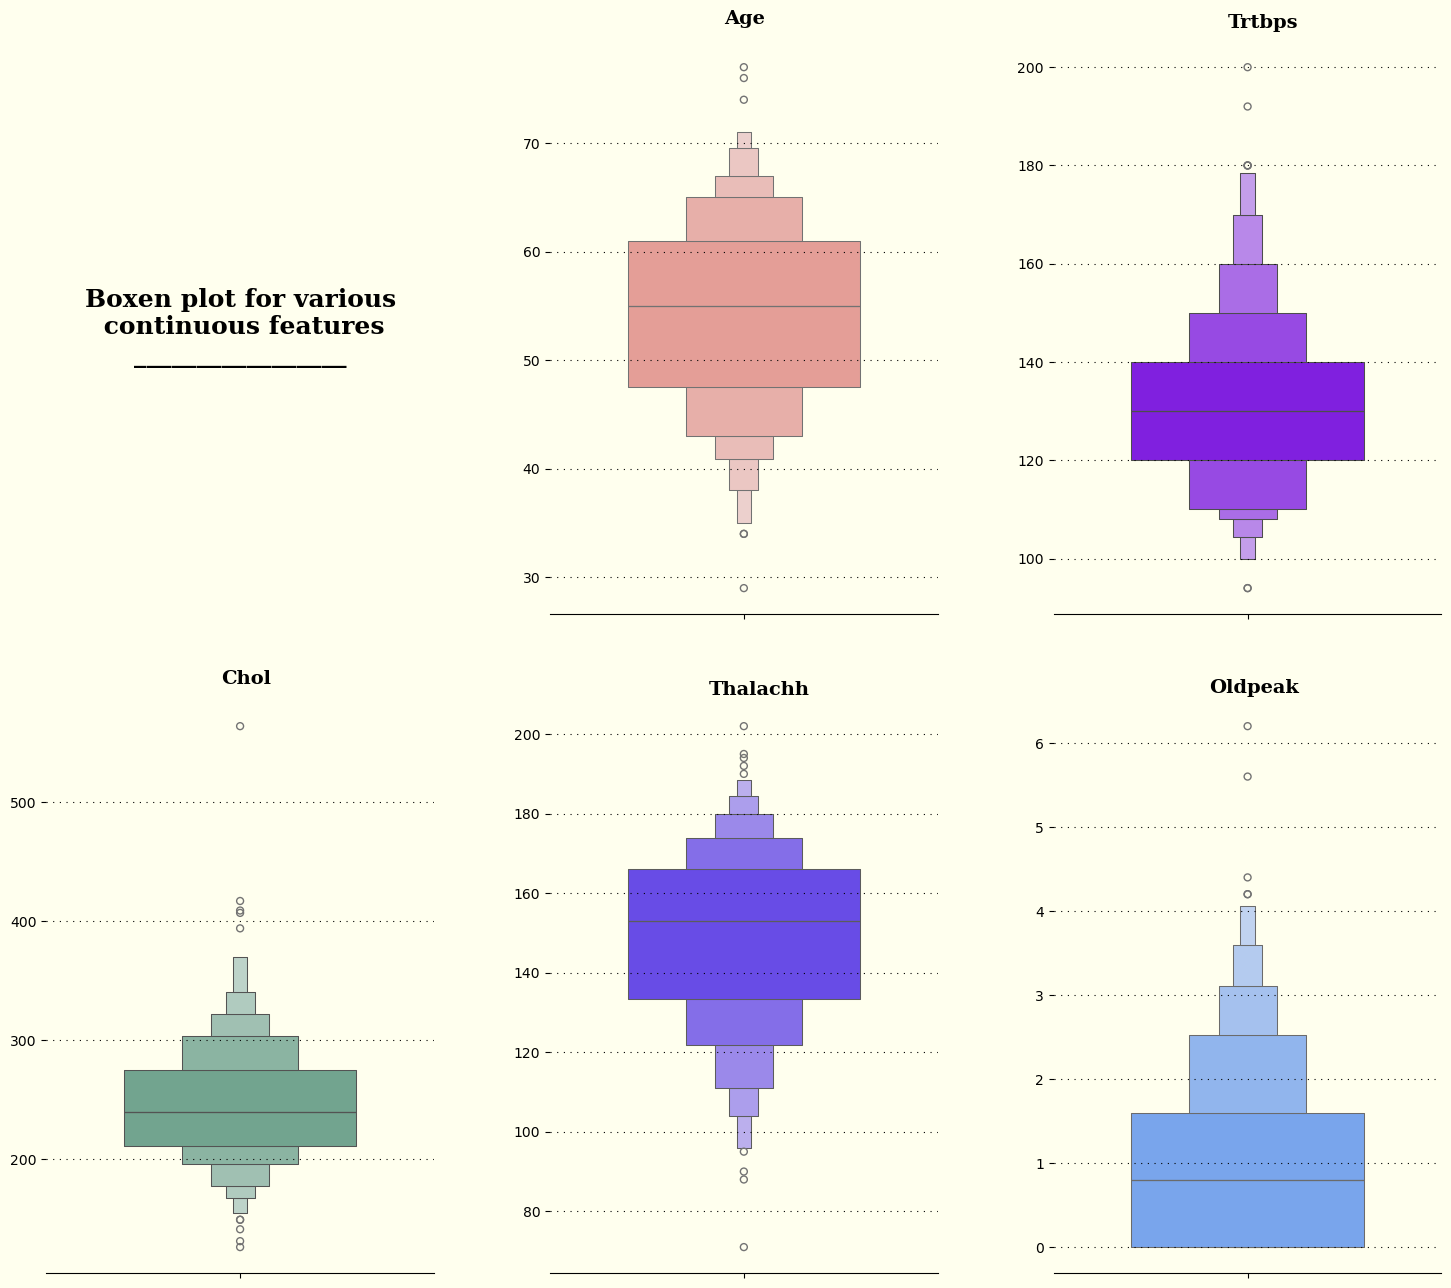

In [9]:
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#FFFFEE"
color_palette =["#f1948a","#8000ff","#00b4d9","#66a1ff","#d9ead3"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxen plot for various\n continuous features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=pandas_df['age'],palette=["#f1948a"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps 
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=pandas_df['trtbps'],palette=["#8000ff"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=pandas_df['chol'],palette=["#6aac90"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=pandas_df['thalachh'],palette=["#5833ff"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=pandas_df['oldpeak'],palette=["#66a1ff"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

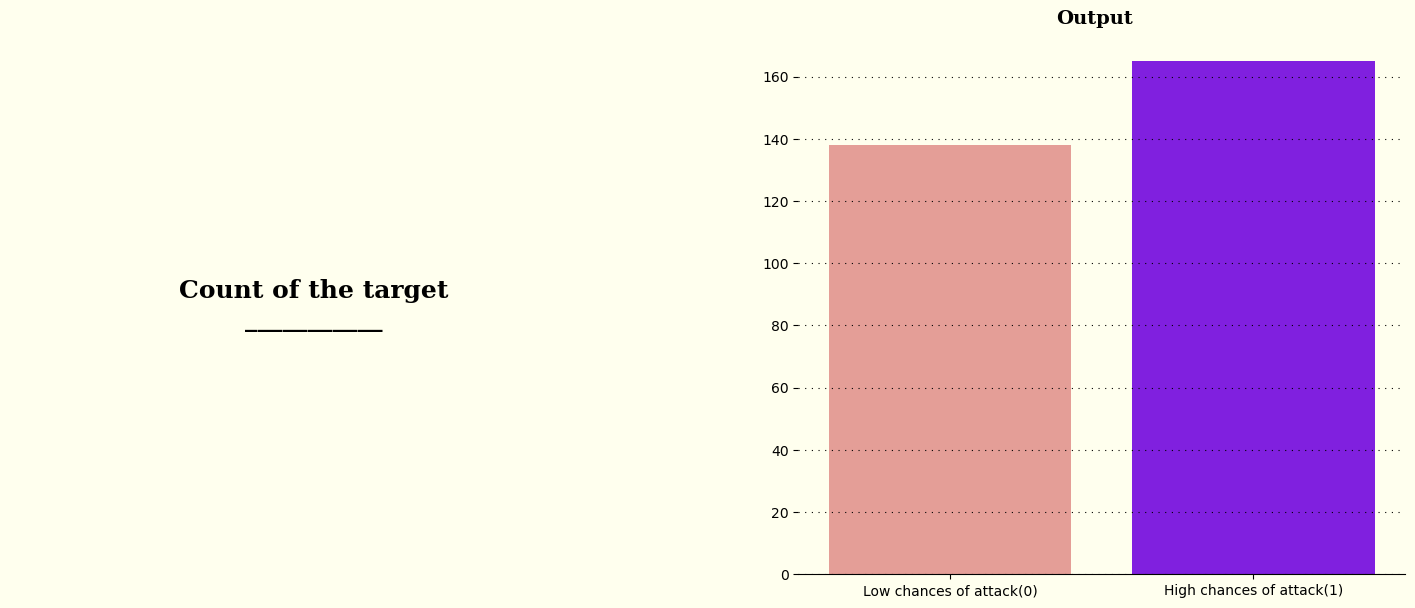

In [10]:
fig = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

background_color = "#FFFFEE"
color_palette = ["#f1948a","#8000ff","#00b4d9","#66a1ff","#d9ead3"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 

# Title of the plot
ax0.text(0.5,0.5,"Count of the target\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Target Count
ax1.text(0.35,177,"Output",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=pandas_df, x = 'output',palette = color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(["Low chances of attack(0)","High chances of attack(1)"])

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

## Distributions of continuous variables for different outputs

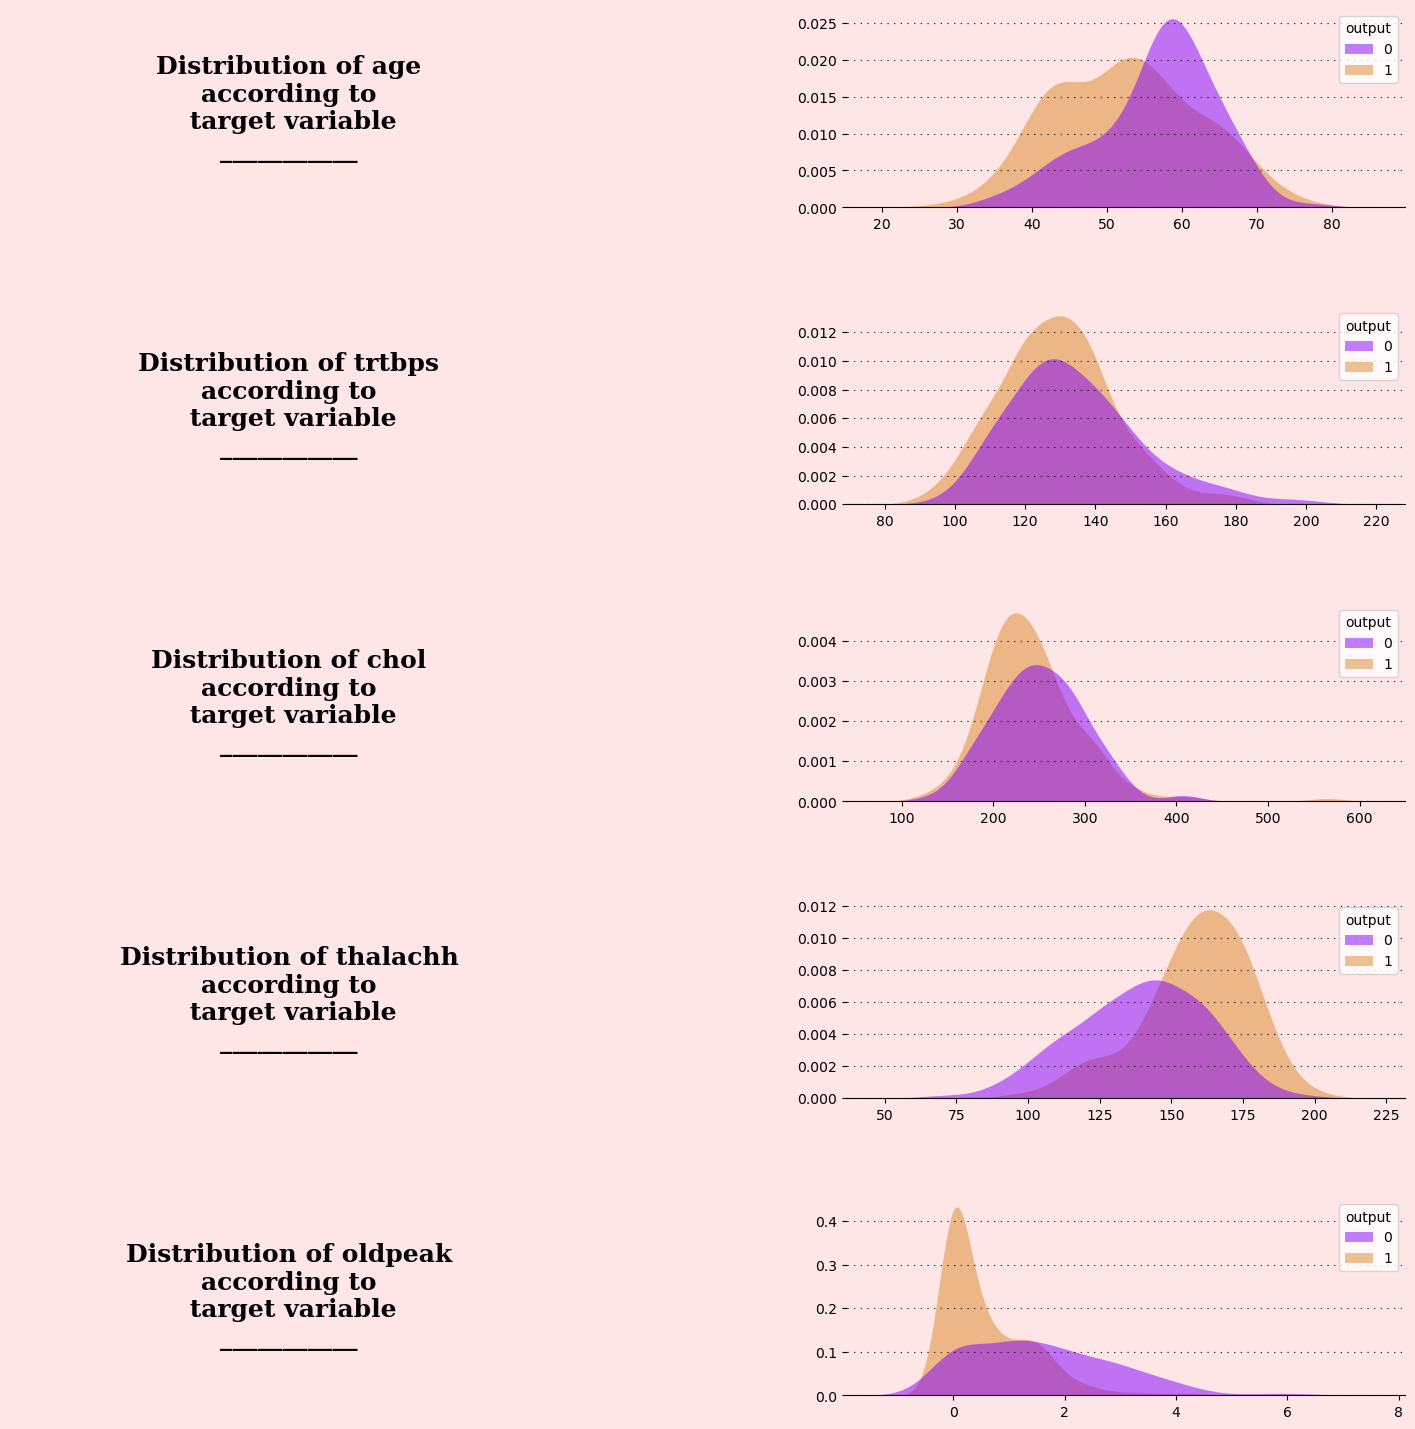

In [11]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(5,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)

# Age title
ax0.text(0.5,0.5,"Distribution of age\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=pandas_df, x='age',hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# TrTbps title
ax2.text(0.5,0.5,"Distribution of trtbps\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# TrTbps
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=pandas_df, x='trtbps',hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Chol title
ax4.text(0.5,0.5,"Distribution of chol\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# Chol
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax5, data=pandas_df, x='chol',hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Thalachh title
ax6.text(0.5,0.5,"Distribution of thalachh\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax6.spines["bottom"].set_visible(False)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.tick_params(left=False, bottom=False)

# Thalachh
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax7, data=pandas_df, x='thalachh',hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Oldpeak title
ax8.text(0.5,0.5,"Distribution of oldpeak\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax8.spines["bottom"].set_visible(False)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.tick_params(left=False, bottom=False)

# Oldpeak
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax9, data=pandas_df, x='oldpeak',hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax9.set_xlabel("")
ax9.set_ylabel("")

for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)


## Combine features into one vector and train test split

In [12]:
# Combine multiple features into one vector
features_uncombined = categorical_cols + continuous_cols
assembler = VectorAssembler(inputCols=features_uncombined, outputCol="features")
df = assembler.transform(df)

In [13]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

## Binary classification with Random Forest

In [14]:
# Create a Random Forest classifier
rf = RandomForestClassifier(labelCol="output", featuresCol="features", numTrees=10)

In [15]:
# Train the model
model = rf.fit(train_data)

# Make predictions on the test data
predictions_rf = model.transform(test_data)

23/11/18 23:19:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [16]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="output", metricName="areaUnderROC")
area_under_curve = evaluator.evaluate(predictions_rf)

# Print the evaluation result
print("Area Under ROC Curve (AUC):", area_under_curve)

# Assuming 'predictions' is the DataFrame containing model predictions
evaluator = MulticlassClassificationEvaluator(labelCol="output", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy:", accuracy)

# For precision, recall, and F1-score
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions_rf)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions_rf)
f1 = evaluator.setMetricName("f1").evaluate(predictions_rf)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Area Under ROC Curve (AUC): 0.881578947368421
Accuracy: 0.8085106382978723
Precision: 0.8074508844868347
Recall: 0.8085106382978723
F1 Score: 0.8076026754638177


## Binary Classification with logistic Regression

In [17]:
# Create a Logistic Regression model
lr = LogisticRegression(labelCol="output", featuresCol="features", maxIter=10)

In [18]:
# Train the model
model = lr.fit(train_data)

# Make predictions on the test data
predictions_lr = model.transform(test_data)

In [19]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="output", metricName="areaUnderROC")
area_under_curve = evaluator.evaluate(predictions_lr)

# Print the evaluation result
print("Area Under ROC Curve (AUC):", area_under_curve)

# Assuming 'predictions' is the DataFrame containing model predictions
evaluator = MulticlassClassificationEvaluator(labelCol="output", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_lr)
print("Accuracy:", accuracy)

# For precision, recall, and F1-score
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions_lr)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions_lr)
f1 = evaluator.setMetricName("f1").evaluate(predictions_lr)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Area Under ROC Curve (AUC): 0.9041353383458647
Accuracy: 0.851063829787234
Precision: 0.8628074053605969
Recall: 0.8510638297872342
F1 Score: 0.8458847279914598


In [20]:
# Stop the Spark session
spark.stop()